# Clonality analysis in 10X data

September 2022 draft

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Loading a big Loom file

In [3]:
filename = 'Raw/JM_10X_merged.loom'

In [4]:
JM_all = sc.read_loom(filename)

In [5]:
JM_all

AnnData object with n_obs × n_vars = 46913 × 36601
    obs: 'clone_id', 'hash.ID', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'orig.ident', 'percent.mt'
    layers: 'counts'

In [6]:
JM_all.obs # Examine cell metadata.

,clone_id,hash.ID,nCount_CH,nCount_RNA,nFeature_CH,nFeature_RNA,orig.ident,percent.mt
CellID,,,,,,,,
exp1_AAACCTGAGACAGGCT-1,exp1_2,exp1_Sample 2,1028.0,6876.0,6,2669,exp1,3.955788
exp1_AAACCTGAGCCCAATT-1,exp1_non,exp1_Sample 1,2166.0,6246.0,6,2368,exp1,2.161383
exp1_AAACCTGAGGACAGAA-1,exp1_non,exp1_Sample 6,813.0,4615.0,6,1718,exp1,2.665222
exp1_AAACCTGCAACAACCT-1,exp1_5,exp1_Sample 5,1092.0,11565.0,6,3613,exp1,2.075227
exp1_AAACCTGCAGACACTT-1,exp1_7,exp1_Sample 4,847.0,4440.0,6,2005,exp1,0.990991
...,...,...,...,...,...,...,...,...
exp3_TTTGTCATCCCACTTG-1,exp3_7,exp3_Sample 5,315.0,2752.0,6,1475,exp3,0.109012
exp3_TTTGTCATCCTATGTT-1,exp3_9,exp3_Sample 3,379.0,2357.0,5,1369,exp3,0.551549
exp3_TTTGTCATCCTCAATT-1,exp3_4,exp3_Sample 3,222.0,2895.0,6,1508,exp3,0.725389


In [7]:
JM_all.var # Examine gene metadata... pretty blank!

""
Gene
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC141272.1
AC023491.2
AC007325.1


In [8]:
JM_all.obs['orig.ident'].value_counts() # Cell counts in each experiment.

exp3    22277
exp1    13493
exp2    11143
Name: orig.ident, dtype: int64

In [9]:
JM_all.layers['counts']

<46913x36601 sparse matrix of type '<class 'numpy.float64'>'
	with 93347218 stored elements in Compressed Sparse Row format>

In [10]:
JM_all.obs['hash.ID'].value_counts() # Sample counts for each experiment.

exp3_Sample 1    7042
exp3_Sample 4    5449
exp3_Sample 2    3868
exp3_Sample 3    3106
exp2_Sample 5    2979
exp2_Sample 6    2596
exp1_Sample 4    2495
exp1_Sample 3    2366
exp1_Sample 6    2334
exp1_Sample 2    2260
exp1_Sample 5    2202
exp2_Sample 2    1842
exp1_Sample 1    1836
exp2_Sample 4    1829
exp3_Sample 5    1759
exp2_Sample 3    1353
exp3_Sample 6    1053
exp2_Sample 1     544
Name: hash.ID, dtype: int64

The data indicates a possible problem -- misidentifying clones/well hashtags perhaps.  Each clone should only be found in one well (wells = Samples 1-6) in Experiment 1.  But a few cells seem to violate this.  See the table below.

In [11]:
test_df = JM_all.obs[JM_all.obs['orig.ident'] == 'exp1']
for c_id in test_df.clone_id.unique():
    print('Clone {}'.format(c_id))
    display(test_df[test_df['clone_id'] == c_id]['hash.ID'].value_counts())

Clone exp1_2


exp1_Sample 2    1180
Name: hash.ID, dtype: int64

Clone exp1_non


exp1_Sample 1    725
exp1_Sample 3    655
exp1_Sample 6    565
exp1_Sample 4    491
exp1_Sample 2    397
exp1_Sample 5    350
Name: hash.ID, dtype: int64

Clone exp1_5


exp1_Sample 5    1517
exp1_Sample 6       5
exp1_Sample 2       2
exp1_Sample 1       2
exp1_Sample 3       1
Name: hash.ID, dtype: int64

Clone exp1_7


exp1_Sample 4    542
Name: hash.ID, dtype: int64

Clone exp1_10


exp1_Sample 4    241
Name: hash.ID, dtype: int64

Clone exp1_21


exp1_Sample 6    520
Name: hash.ID, dtype: int64

Clone exp1_11


exp1_Sample 4    482
Name: hash.ID, dtype: int64

Clone exp1_19


exp1_Sample 2    309
Name: hash.ID, dtype: int64

Clone exp1_26


exp1_Sample 6    220
Name: hash.ID, dtype: int64

Clone exp1_23


exp1_Sample 2    263
Name: hash.ID, dtype: int64

Clone exp1_4


exp1_Sample 6    908
Name: hash.ID, dtype: int64

Clone exp1_18


exp1_Sample 1    82
Name: hash.ID, dtype: int64

Clone exp1_36


exp1_Sample 3    36
Name: hash.ID, dtype: int64

Clone exp1_24


exp1_Sample 3    174
Name: hash.ID, dtype: int64

Clone exp1_29


exp1_Sample 3    145
Name: hash.ID, dtype: int64

Clone exp1_14


exp1_Sample 4    536
Name: hash.ID, dtype: int64

Clone exp1_12


exp1_Sample 3    357
Name: hash.ID, dtype: int64

Clone exp1_8


exp1_Sample 4    75
Name: hash.ID, dtype: int64

Clone exp1_17


exp1_Sample 1    269
Name: hash.ID, dtype: int64

Clone exp1_3


exp1_Sample 3    988
Name: hash.ID, dtype: int64

Clone exp1_31


exp1_Sample 5    53
exp1_Sample 1     1
exp1_Sample 4     1
Name: hash.ID, dtype: int64

Clone exp1_28


exp1_Sample 4    127
Name: hash.ID, dtype: int64

Clone exp1_45


exp1_Sample 3    10
Name: hash.ID, dtype: int64

Clone exp1_9


exp1_Sample 2    100
Name: hash.ID, dtype: int64

Clone exp1_16


exp1_Sample 5    266
exp1_Sample 6      2
exp1_Sample 2      1
Name: hash.ID, dtype: int64

Clone exp1_15


exp1_Sample 1    222
Name: hash.ID, dtype: int64

Clone exp1_1


exp1_Sample 1    476
exp1_Sample 6      1
Name: hash.ID, dtype: int64

Clone exp1_13


exp1_Sample 1    57
Name: hash.ID, dtype: int64

Clone exp1_40


exp1_Sample 6    39
Name: hash.ID, dtype: int64

Clone exp1_41


exp1_Sample 6    74
Name: hash.ID, dtype: int64

Clone exp1_44


exp1_Sample 5    5
Name: hash.ID, dtype: int64

Clone exp1_33


exp1_Sample 2    7
Name: hash.ID, dtype: int64

Clone exp1_39


exp1_Sample 2    1
Name: hash.ID, dtype: int64

Clone exp1_6


exp1_Sample 5    11
Name: hash.ID, dtype: int64

Clone exp1_46


exp1_Sample 1    2
Name: hash.ID, dtype: int64

So now we reassign those cells which seem to be assigned to the wrong sample.

In [12]:
test_df = JM_all.obs[JM_all.obs['orig.ident'] == 'exp1']
for c_id in test_df.clone_id.unique():
    vc = test_df[test_df['clone_id'] == c_id]['hash.ID'].value_counts()
    if c_id != 'exp1_non':
        if len(vc) > 1:
            print('----')
            print('Alert!')
            print(vc)
            right_sample = vc.idxmax()
            cells = test_df[test_df['clone_id'] == c_id].index
            JM_all.obs.loc[cells,'hash.ID'] = right_sample
            num_corr = len(cells) - vc[right_sample]
            print('Sample number (hashID) changed to {} for {} cells'.format(right_sample, num_corr))
            print('----')
        else:
            print('Clone {} ok.'.format(c_id))
    else: 
        print('Clone non.')

Clone exp1_2 ok.
Clone non.
----
Alert!
exp1_Sample 5    1517
exp1_Sample 6       5
exp1_Sample 2       2
exp1_Sample 1       2
exp1_Sample 3       1
Name: hash.ID, dtype: int64
Sample number (hashID) changed to exp1_Sample 5 for 10 cells
----
Clone exp1_7 ok.
Clone exp1_10 ok.
Clone exp1_21 ok.
Clone exp1_11 ok.
Clone exp1_19 ok.
Clone exp1_26 ok.
Clone exp1_23 ok.
Clone exp1_4 ok.
Clone exp1_18 ok.
Clone exp1_36 ok.
Clone exp1_24 ok.
Clone exp1_29 ok.
Clone exp1_14 ok.
Clone exp1_12 ok.
Clone exp1_8 ok.
Clone exp1_17 ok.
Clone exp1_3 ok.
----
Alert!
exp1_Sample 5    53
exp1_Sample 1     1
exp1_Sample 4     1
Name: hash.ID, dtype: int64
Sample number (hashID) changed to exp1_Sample 5 for 2 cells
----
Clone exp1_28 ok.
Clone exp1_45 ok.
Clone exp1_9 ok.
----
Alert!
exp1_Sample 5    266
exp1_Sample 6      2
exp1_Sample 2      1
Name: hash.ID, dtype: int64
Sample number (hashID) changed to exp1_Sample 5 for 3 cells
----
Clone exp1_15 ok.
----
Alert!
exp1_Sample 1    476
exp1_Sample 6    

In [13]:
test_df = JM_all.obs[JM_all.obs['orig.ident'] == 'exp1']
for c_id in test_df.clone_id.unique():
    print('Clone {}'.format(c_id))
    display(test_df[test_df['clone_id'] == c_id]['hash.ID'].value_counts())

Clone exp1_2


exp1_Sample 2    1180
Name: hash.ID, dtype: int64

Clone exp1_non


exp1_Sample 1    725
exp1_Sample 3    655
exp1_Sample 6    565
exp1_Sample 4    491
exp1_Sample 2    397
exp1_Sample 5    350
Name: hash.ID, dtype: int64

Clone exp1_5


exp1_Sample 5    1527
Name: hash.ID, dtype: int64

Clone exp1_7


exp1_Sample 4    542
Name: hash.ID, dtype: int64

Clone exp1_10


exp1_Sample 4    241
Name: hash.ID, dtype: int64

Clone exp1_21


exp1_Sample 6    520
Name: hash.ID, dtype: int64

Clone exp1_11


exp1_Sample 4    482
Name: hash.ID, dtype: int64

Clone exp1_19


exp1_Sample 2    309
Name: hash.ID, dtype: int64

Clone exp1_26


exp1_Sample 6    220
Name: hash.ID, dtype: int64

Clone exp1_23


exp1_Sample 2    263
Name: hash.ID, dtype: int64

Clone exp1_4


exp1_Sample 6    908
Name: hash.ID, dtype: int64

Clone exp1_18


exp1_Sample 1    82
Name: hash.ID, dtype: int64

Clone exp1_36


exp1_Sample 3    36
Name: hash.ID, dtype: int64

Clone exp1_24


exp1_Sample 3    174
Name: hash.ID, dtype: int64

Clone exp1_29


exp1_Sample 3    145
Name: hash.ID, dtype: int64

Clone exp1_14


exp1_Sample 4    536
Name: hash.ID, dtype: int64

Clone exp1_12


exp1_Sample 3    357
Name: hash.ID, dtype: int64

Clone exp1_8


exp1_Sample 4    75
Name: hash.ID, dtype: int64

Clone exp1_17


exp1_Sample 1    269
Name: hash.ID, dtype: int64

Clone exp1_3


exp1_Sample 3    988
Name: hash.ID, dtype: int64

Clone exp1_31


exp1_Sample 5    55
Name: hash.ID, dtype: int64

Clone exp1_28


exp1_Sample 4    127
Name: hash.ID, dtype: int64

Clone exp1_45


exp1_Sample 3    10
Name: hash.ID, dtype: int64

Clone exp1_9


exp1_Sample 2    100
Name: hash.ID, dtype: int64

Clone exp1_16


exp1_Sample 5    269
Name: hash.ID, dtype: int64

Clone exp1_15


exp1_Sample 1    222
Name: hash.ID, dtype: int64

Clone exp1_1


exp1_Sample 1    477
Name: hash.ID, dtype: int64

Clone exp1_13


exp1_Sample 1    57
Name: hash.ID, dtype: int64

Clone exp1_40


exp1_Sample 6    39
Name: hash.ID, dtype: int64

Clone exp1_41


exp1_Sample 6    74
Name: hash.ID, dtype: int64

Clone exp1_44


exp1_Sample 5    5
Name: hash.ID, dtype: int64

Clone exp1_33


exp1_Sample 2    7
Name: hash.ID, dtype: int64

Clone exp1_39


exp1_Sample 2    1
Name: hash.ID, dtype: int64

Clone exp1_6


exp1_Sample 5    11
Name: hash.ID, dtype: int64

Clone exp1_46


exp1_Sample 1    2
Name: hash.ID, dtype: int64

Now we do some string processing to avoid problems.

In [14]:
JM_all.obs['hash.ID'] = JM_all.obs['hash.ID'].str.replace(' ', '')
JM_all.obs['hash.ID'].unique()

array(['exp1_Sample2', 'exp1_Sample1', 'exp1_Sample6', 'exp1_Sample5',
       'exp1_Sample4', 'exp1_Sample3', 'exp2_Sample3', 'exp2_Sample6',
       'exp2_Sample4', 'exp2_Sample1', 'exp2_Sample2', 'exp2_Sample5',
       'exp3_Sample2', 'exp3_Sample1', 'exp3_Sample4', 'exp3_Sample3',
       'exp3_Sample5', 'exp3_Sample6'], dtype=object)

In [15]:
JM_all.obs.columns = [col.replace('.','_') for col in JM_all.obs.columns]
JM_all.obs.columns = [col.replace('clone_id','clone_ID') for col in JM_all.obs.columns]

We extract the data from clone_ID and hash_ID into new metadata attributes called simply "clone" and "well" and "experiment".

In [16]:
JM_all.obs['clone'] = JM_all.obs.clone_ID.apply(lambda x : x.split('_')[1])
JM_all.obs['well'] = JM_all.obs.hash_ID.apply(lambda x : x.split('_')[1])
JM_all.obs['experiment'] = JM_all.obs.orig_ident

# CD4 vs CD8 scoring

It is pretty easy to distinguish CD4 from CD8 cells.  We use the three genes:  CD4, CD8A, CD8B, essentially giving each of them a "vote".  A clone consists of all CD4 or all CD8 cells, so we vote the entire clone to be a CD4 or CD8 cell based on the clonal mean for each gene's expression.  

In [17]:
def CD_score(adata):
    CD_df = pd.DataFrame(index=adata.obs.index)
    for gene in ['CD4','CD8A','CD8B']:
        if gene in adata.var_names:
            CD_df[gene] = adata.to_df()[gene]
        else:
            CD_df[gene] = 0.0
    CD_means = CD_df.groupby(adata.obs.clone).mean()
    CD_scores = ((CD_means['CD8A'] > 1).astype(int) + 
                 (CD_means['CD8B'] > 1).astype(int) - 
                 (CD_means['CD4'] > 0.4).astype(int)) # Manually found cutoffs.
    CD_scores = CD_scores.map({-1 : 'CD4', 2 : 'CD8'})
    CD_scores['non'] = 'unknown'
    return CD_scores

In [18]:
CD_scores = CD_score(JM_all)
JM_all.obs['CD_type'] = JM_all.obs.clone.map(CD_scores)

In [19]:
meta_df = JM_all.obs
meta_df.head()

,clone_ID,hash_ID,nCount_CH,nCount_RNA,nFeature_CH,nFeature_RNA,orig_ident,percent_mt,clone,well,experiment,CD_type
CellID,,,,,,,,,,,,
exp1_AAACCTGAGACAGGCT-1,exp1_2,exp1_Sample2,1028.0,6876.0,6,2669,exp1,3.955788,2,Sample2,exp1,CD4
exp1_AAACCTGAGCCCAATT-1,exp1_non,exp1_Sample1,2166.0,6246.0,6,2368,exp1,2.161383,non,Sample1,exp1,unknown
exp1_AAACCTGAGGACAGAA-1,exp1_non,exp1_Sample6,813.0,4615.0,6,1718,exp1,2.665222,non,Sample6,exp1,unknown
exp1_AAACCTGCAACAACCT-1,exp1_5,exp1_Sample5,1092.0,11565.0,6,3613,exp1,2.075227,5,Sample5,exp1,CD4
exp1_AAACCTGCAGACACTT-1,exp1_7,exp1_Sample4,847.0,4440.0,6,2005,exp1,0.990991,7,Sample4,exp1,CD4


In [20]:
meta_df.CD_type.value_counts()

CD4        27056
unknown    17150
CD8         2707
Name: CD_type, dtype: int64

Note that this CD4 vs CD8 voting yields *unanimous* results for each identified clone.  

In [21]:
meta_df.to_csv('Processed/Allcells_metadata.csv')

## Breaking into smaller experiment files

In [22]:
JM = {}
datasets = JM_all.obs['hash_ID'].unique()
for ds in datasets:
    ad_temp = JM_all[JM_all.obs['hash_ID'] == ds]
    JM[ds] = sc.AnnData(ad_temp.layers['counts'])
    JM[ds].obs = ad_temp.obs
    JM[ds].var = ad_temp.var

In [23]:
JM['exp1_Sample1'].obs

,clone_ID,hash_ID,nCount_CH,nCount_RNA,nFeature_CH,nFeature_RNA,orig_ident,percent_mt,clone,well,experiment,CD_type
CellID,,,,,,,,,,,,
exp1_AAACCTGAGCCCAATT-1,exp1_non,exp1_Sample1,2166.0,6246.0,6,2368,exp1,2.161383,non,Sample1,exp1,unknown
exp1_AAACCTGTCCGCATAA-1,exp1_18,exp1_Sample1,15789.0,5096.0,6,2207,exp1,2.217425,18,Sample1,exp1,CD4
exp1_AAACGGGGTTACGGAG-1,exp1_non,exp1_Sample1,3081.0,5905.0,6,1974,exp1,3.065199,non,Sample1,exp1,unknown
exp1_AAACGGGTCGAATCCA-1,exp1_17,exp1_Sample1,2479.0,4264.0,6,1879,exp1,1.993433,17,Sample1,exp1,CD8
exp1_AAACGGGTCTGTGCAA-1,exp1_non,exp1_Sample1,3424.0,1655.0,6,1167,exp1,3.746224,non,Sample1,exp1,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
exp1_TTTGGTTTCACATACG-1,exp1_1,exp1_Sample1,18033.0,4451.0,6,2066,exp1,2.269153,1,Sample1,exp1,CD4
exp1_TTTGTCAAGCTAGTCT-1,exp1_1,exp1_Sample1,3656.0,8112.0,6,2748,exp1,2.465483,1,Sample1,exp1,CD4
exp1_TTTGTCACAAGAAAGG-1,exp1_17,exp1_Sample1,3510.0,4699.0,6,2146,exp1,2.085550,17,Sample1,exp1,CD8


In [24]:
import sys
sys.getsizeof(JM[ds])

19409313

In [25]:
for ds in datasets:
    fn = 'Raw/JM_10X_'+ds+'.loom'
    JM[ds].write_loom(fn)

In [26]:
len(datasets)

18

# Preprocessing

We start by loading the data from separate loom files.

In [27]:
JM = {}
for ds in datasets:
    fn = 'Raw/JM_10X_'+ds+'.loom'
    JM[ds] = sc.read_loom(fn)

## Quality control

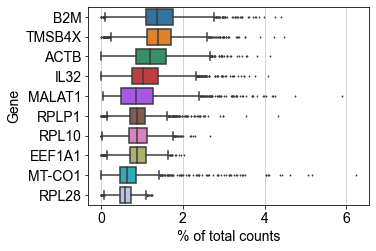

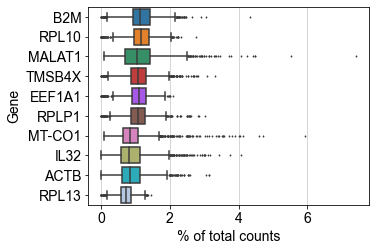

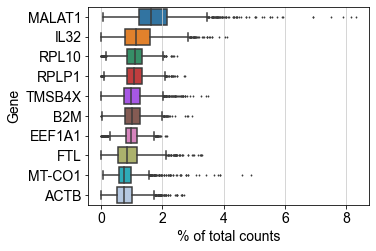

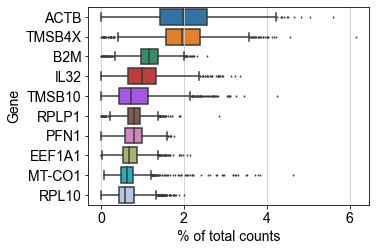

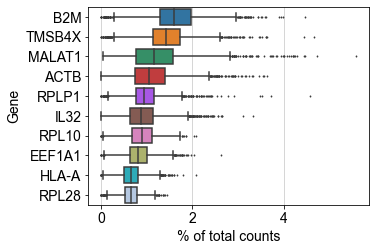

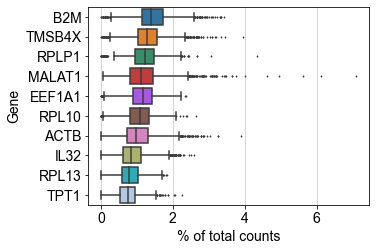

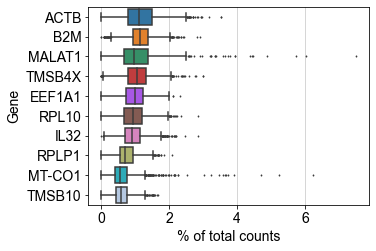

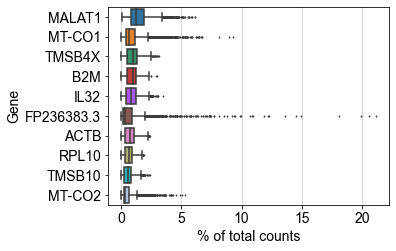

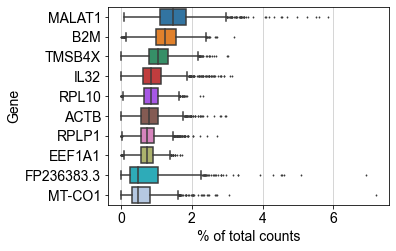

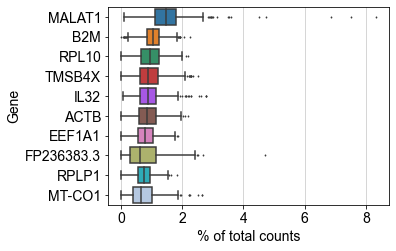

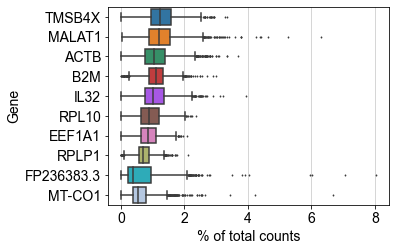

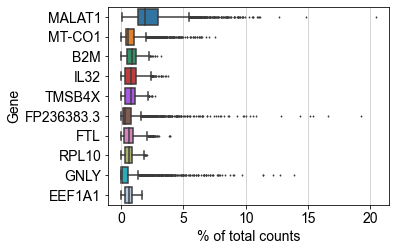

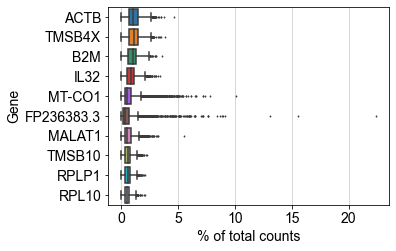

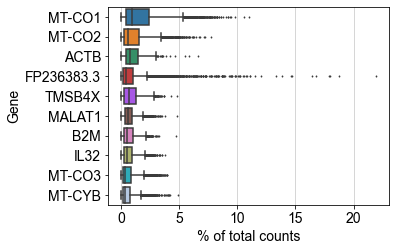

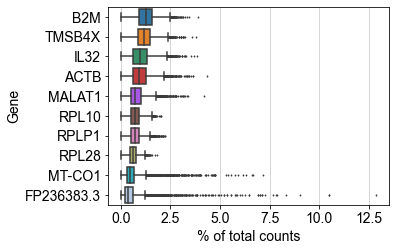

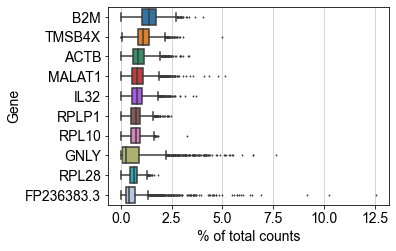

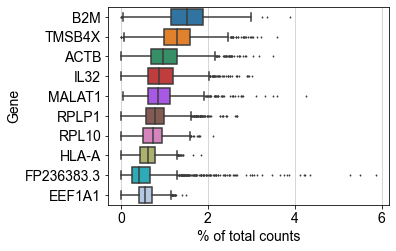

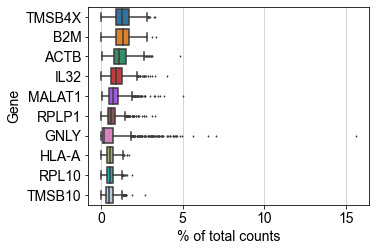

In [28]:
for ds in datasets:
    sc.pl.highest_expr_genes(JM[ds], n_top=10, log=False, show=False)

In [29]:
for ds in datasets:
    JM[ds].var['mt'] = JM[ds].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(JM[ds], qc_vars=['mt'], percent_top=None, inplace=True)

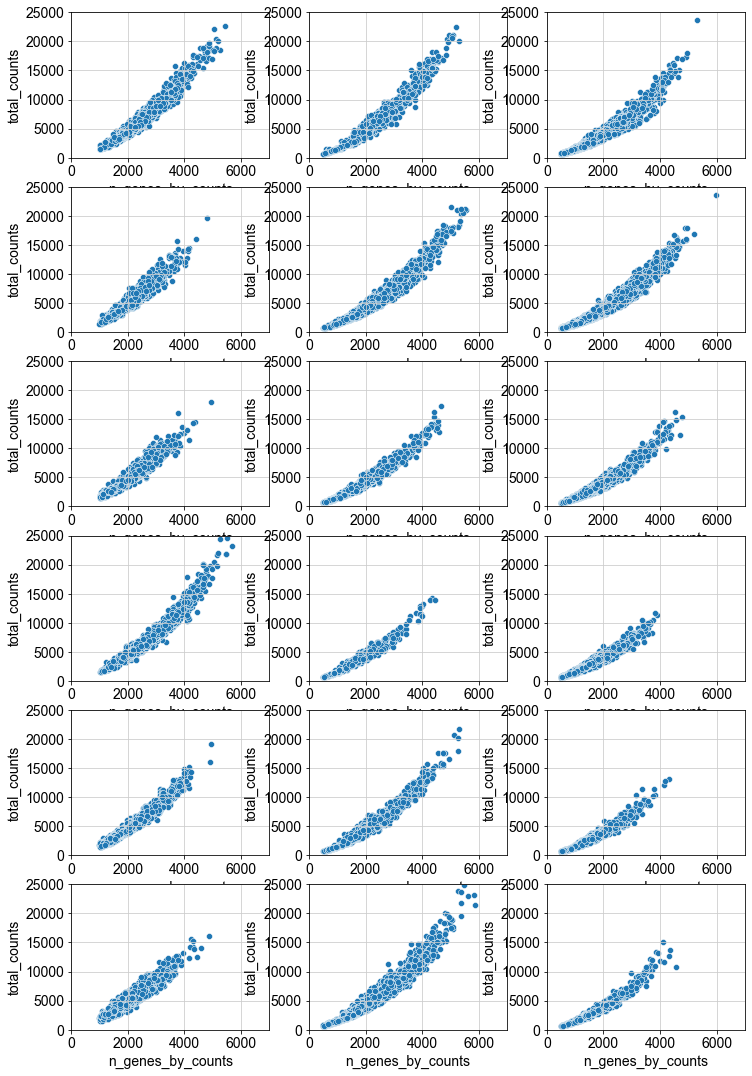

In [30]:
fig,ax = plt.subplots(6,3,figsize=(12,18))
for j,ds in enumerate(datasets):
    curr_ax = ax[j%6, j//6]
    sns.scatterplot(x='n_genes_by_counts', y='total_counts', data=JM[ds].obs, ax=curr_ax)
    curr_ax.set_xlim(0,7000)
    curr_ax.set_ylim(0,25000)
plt.show()

## Note:  we might want to filter out some cells here based on total counts?  

## Normalization and filtering

Normalization to 10000-count, excluding highly variable genes

In [31]:
for ds in datasets:
    sc.pp.highly_variable_genes(JM[ds], n_top_genes=1000, flavor='seurat_v3')
    sc.pp.normalize_total(JM[ds], target_sum = 10000, exclude_highly_expressed=True) #Normalize 

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Filter out never expressed genes.

In [32]:
for ds in datasets:
    genes_before = JM[ds].n_vars
    sc.pp.filter_genes(JM[ds], min_counts=1) # At least 1 count.
    genes_after = JM[ds].n_vars
    print('Dataset {} has {} genes before and {} after filtering.'.format(ds, genes_before,genes_after))

Dataset exp1_Sample2 has 36601 genes before and 19561 after filtering.
Dataset exp1_Sample1 has 36601 genes before and 19146 after filtering.
Dataset exp1_Sample6 has 36601 genes before and 19950 after filtering.
Dataset exp1_Sample5 has 36601 genes before and 19359 after filtering.
Dataset exp1_Sample4 has 36601 genes before and 19434 after filtering.
Dataset exp1_Sample3 has 36601 genes before and 19093 after filtering.
Dataset exp2_Sample3 has 36601 genes before and 17913 after filtering.
Dataset exp2_Sample6 has 36601 genes before and 20525 after filtering.
Dataset exp2_Sample4 has 36601 genes before and 19091 after filtering.
Dataset exp2_Sample1 has 36601 genes before and 15588 after filtering.
Dataset exp2_Sample2 has 36601 genes before and 18607 after filtering.
Dataset exp2_Sample5 has 36601 genes before and 21028 after filtering.
Dataset exp3_Sample2 has 36601 genes before and 20403 after filtering.
Dataset exp3_Sample1 has 36601 genes before and 22040 after filtering.
Datase

Pseudo-log normalize.

In [33]:
for ds in datasets:
    sc.pp.log1p(JM[ds]) #pseudo-log transform

Exclude T-cell receptor genes.

In [34]:
def drop_TRs(ad, filename='Raw/TR_gene_data.csv'):
    ad_out = ad
    TR_gene_df = pd.read_csv(filename, index_col=0)
    TR_genes = TR_gene_df['gene_name'].values
    bad_genes = [gene for gene in ad_out.var_names if gene in TR_genes]
    print('{} genes removed.'.format(len(bad_genes)))
    keep_genes = [gene for gene in ad_out.var_names if not gene in bad_genes]
    ad_out = ad_out[:, keep_genes]
    return ad_out

In [35]:
for ds in datasets:
    JM[ds] = drop_TRs(JM[ds])

153 genes removed.
149 genes removed.
155 genes removed.
162 genes removed.
160 genes removed.
163 genes removed.
142 genes removed.
177 genes removed.
155 genes removed.
131 genes removed.
157 genes removed.
178 genes removed.
167 genes removed.
180 genes removed.
170 genes removed.
159 genes removed.
144 genes removed.
144 genes removed.


In [36]:
for ds in datasets:
    print('Summary of AnnData object for (shape = #samples x #genes), {}'.format(ds))
    print(JM[ds])
    hrule()

Summary of AnnData object for (shape = #samples x #genes), exp1_Sample2
View of AnnData object with n_obs × n_vars = 2257 × 19408
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'well', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'hvg', 'log1p'
Summary of AnnData object for (shape = #samples x #genes), exp1_Sample1
View of AnnData object with n_obs × n_vars = 1834 × 18997
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'well', 'n_genes_by_counts', 

# Make clonal analysis datasets

In [37]:
ad = {}
for ds in datasets:
    adata = JM[ds].copy()
    print('Dataset {} has {} cells'.format(ds, len(adata.obs)))
    e_ds = ds.split('_')[0]
    has_clone = adata.obs[adata.obs.clone_ID != e_ds+'_non'].index
    print('{} cells have an assigned clone.'.format(len(has_clone)))
    vcs = adata.obs.loc[has_clone].clone_ID.value_counts()
    allclones = vcs.index
    bigclones = vcs[vcs >= 10].index
    print('{} clones with at least 10 cells each'.format(len(bigclones)))
    bc_cells = adata.obs[adata.obs.clone_ID.isin(bigclones)].index
    print('{} cells belong to these big-enough clones.'.format(len(bc_cells)))
    print('New AnnData Object Created for {}.'.format(ds))
    goodcells = adata.obs[adata.obs.clone_ID.isin(allclones)].index
    ad[ds] = adata[goodcells]
    #print(ad[ds])
    hrule()

Dataset exp1_Sample2 has 2257 cells
1860 cells have an assigned clone.
4 clones with at least 10 cells each
1852 cells belong to these big-enough clones.
New AnnData Object Created for exp1_Sample2.
Dataset exp1_Sample1 has 1834 cells
1109 cells have an assigned clone.
5 clones with at least 10 cells each
1107 cells belong to these big-enough clones.
New AnnData Object Created for exp1_Sample1.
Dataset exp1_Sample6 has 2326 cells
1761 cells have an assigned clone.
5 clones with at least 10 cells each
1761 cells belong to these big-enough clones.
New AnnData Object Created for exp1_Sample6.
Dataset exp1_Sample5 has 2217 cells
1867 cells have an assigned clone.
4 clones with at least 10 cells each
1862 cells belong to these big-enough clones.
New AnnData Object Created for exp1_Sample5.
Dataset exp1_Sample4 has 2494 cells
2003 cells have an assigned clone.
6 clones with at least 10 cells each
2003 cells belong to these big-enough clones.
New AnnData Object Created for exp1_Sample4.
Datas

In [38]:
display(ad[ds].obs)

,CD_type,clone,clone_ID,experiment,hash_ID,nCount_CH,nCount_RNA,nFeature_CH,nFeature_RNA,orig_ident,percent_mt,well,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
CellID,,,,,,,,,,,,,,,,,,,
exp3_AAACCTGGTCCGAAGA-1,CD4,2,exp3_2,exp3,exp3_Sample6,545.0,4069.0,6,2038,exp3,0.909314,Sample6,2038,7.620215,4069.0,8.311399,37.0,3.637586,0.909314
exp3_AAACCTGGTTGGTTTG-1,CD4,1,exp3_1,exp3,exp3_Sample6,469.0,3501.0,5,1780,exp3,1.142531,Sample6,1780,7.484930,3501.0,8.161090,40.0,3.713572,1.142531
exp3_AAACGGGAGATAGTCA-1,CD4,2,exp3_2,exp3,exp3_Sample6,361.0,3496.0,6,1704,exp3,1.344394,Sample6,1704,7.441320,3496.0,8.159660,47.0,3.871201,1.344394
exp3_AAAGATGAGGTGGGTT-1,CD4,12,exp3_12,exp3,exp3_Sample6,446.0,4648.0,6,2018,exp3,0.666954,Sample6,2018,7.610358,4648.0,8.444407,31.0,3.465736,0.666954
exp3_AAAGATGTCCAACCAA-1,CD4,8,exp3_8,exp3,exp3_Sample6,557.0,2349.0,6,1577,exp3,8.812261,Sample6,1577,7.363914,2349.0,7.762171,207.0,5.337538,8.812261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
exp3_TTTATGCAGGAGCGAG-1,CD4,2,exp3_2,exp3,exp3_Sample6,662.0,2778.0,5,1503,exp3,0.575954,Sample6,1503,7.315884,2778.0,7.929846,16.0,2.833213,0.575954
exp3_TTTATGCCACACAGAG-1,CD4,13,exp3_13,exp3,exp3_Sample6,361.0,2543.0,6,1375,exp3,1.297680,Sample6,1375,7.226936,2543.0,7.841493,33.0,3.526361,1.297680
exp3_TTTCCTCAGTTACGGG-1,CD4,2,exp3_2,exp3,exp3_Sample6,955.0,4277.0,6,2102,exp3,1.285948,Sample6,2102,7.651120,4277.0,8.361241,55.0,4.025352,1.285948


In [39]:
for ds in datasets:
    print('CD4 and CD8 types in {}'.format(ds))
    print(ad[ds].obs.CD_type.value_counts())
    hrule()
    

CD4 and CD8 types in exp1_Sample2
CD4    1597
CD8     263
Name: CD_type, dtype: int64
CD4 and CD8 types in exp1_Sample1
CD4    840
CD8    269
Name: CD_type, dtype: int64
CD4 and CD8 types in exp1_Sample6
CD4    1467
CD8     294
Name: CD_type, dtype: int64
CD4 and CD8 types in exp1_Sample5
CD4    1538
CD8     329
Name: CD_type, dtype: int64
CD4 and CD8 types in exp1_Sample4
CD4    1467
CD8     536
Name: CD_type, dtype: int64
CD4 and CD8 types in exp1_Sample3
CD4    1519
CD8     191
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample3
CD4    972
CD8      2
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample6
CD4    1522
CD8     113
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample4
CD4    914
CD8    184
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample1
CD4    237
CD8     24
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample2
CD4    1083
CD8     154
Name: CD_type, dtype: int64
CD4 and CD8 types in exp2_Sample5
CD4    1476
CD8     348
Name

In [40]:
ads_8 = {}
ads_4 = {}
for ds in datasets:
    print('Filtering non-expressed genes.')
    ads_4[ds] = ad[ds][ad[ds].obs.CD_type == 'CD4']
    ads_8[ds] = ad[ds][ad[ds].obs.CD_type == 'CD8']
    sc.pp.filter_genes(ads_4[ds], min_counts=1) # At least 1 count.
    sc.pp.filter_genes(ads_8[ds], min_counts=1) # At least 1 count.
    hrule()

Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.
Filtering non-expressed genes.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Filtering non-expressed genes.


Now we create our loom files for CD4 and CD8 T-=cells within each dataset.

In [41]:
datasets

array(['exp1_Sample2', 'exp1_Sample1', 'exp1_Sample6', 'exp1_Sample5',
       'exp1_Sample4', 'exp1_Sample3', 'exp2_Sample3', 'exp2_Sample6',
       'exp2_Sample4', 'exp2_Sample1', 'exp2_Sample2', 'exp2_Sample5',
       'exp3_Sample2', 'exp3_Sample1', 'exp3_Sample4', 'exp3_Sample3',
       'exp3_Sample5', 'exp3_Sample6'], dtype=object)

In [42]:
for ds in datasets:
    fn = 'Processed/JM_10X_'+ds
    if ads_4[ds].n_obs > 0:
        ads_4[ds].write_loom(fn+'_CD4.loom')
    if ads_8[ds].n_obs > 0:
        ads_8[ds].write_loom(fn+'_CD8.loom')